In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# View current working directory
!pwd

/Users/sumi/Desktop/SpectraRAG/Notebooks


In [3]:
# Change to the parent directory
os.chdir('../')
!pwd

/Users/sumi/Desktop/SpectraRAG


In [ ]:
# Load environment variables
os.environ["GEMINI_API_KEY"] = os.getenv('GOOGLE_API_KEY')


In [5]:
# Test the LLM
from langchain_google_genai import ChatGoogleGenerativeAI

llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")
response=llm.invoke("Hi!")
response.content

'Hi there! How can I help you today?'

In [6]:
# Define the state schema
from pydantic import BaseModel, Field
from operator import add
from typing import TypedDict,Optional, Any, Annotated, List, Dict
from langchain.schema import Document


from pydantic import BaseModel

class BaseVectorDBState(BaseModel):
    vector_db_path: str
    vector_db_ready: bool = False

class EmbederState(BaseVectorDBState):
    file_path: str
    file_exists: bool = False
    documents: list[Document] = []

class RetrieverState(BaseVectorDBState):
    retriever_path: str
    retriever_ready: bool = False
    query: str
    results: list = []


# MCP Input/Output schemas
class EmbedderInput(TypedDict):
    file_path: str
    vector_db_path: str

class EmbedderOutput(TypedDict):
    success: bool
    message: str
    

In [7]:
# Check if file exists
def check_file_exists(state: EmbederState)-> EmbederState:
    """Check if the file exists in the specified path."""
    path=state.file_path
    state.file_exists=os.path.exists(path)
    return state

**NOTE:**
In this project I'm using Landing AI's `Agentic Document Extraction(ADE)` is a foundation model-assisted document extraction system designed to intelligently parse unstructured or semi-structured documents using task-specific agents. Unlike PyPDFLoader or PDFPlumberLoader, which primarily extract raw or semi-structured data from PDFs, ADE uses LLMs to understand and extract structured data with reasoning.

ADE is ideal for extracting information like:
- Invoices, receipts, and forms
- Contracts or legal documents
- Financial reports
- Medical records or lab reports

However It might be `bit slower` than the usual PDFLoaders. 
Explore it Here: [ADE](https://github.com/landing-ai/agentic-doc)

In [8]:
####### TESTING THE ADE PARSER ######
from agentic_doc.parse import parse

# Parse a single PDF
results = parse("temp/Coding-Round-Task.pdf")
doc = results[0]
print(doc.markdown)
print(doc.chunks)

2025-07-22 18:50:40 [info   ] Settings loaded: {
  "endpoint_host": "https://api.va.landing.ai",
  "vision_agent_api_key": "ajhtO[REDACTED]",
  "batch_size": 4,
  "max_workers": 5,
  "max_retries": 100,
  "max_retry_wait_time": 60,
  "retry_logging_style": "log_msg",
  "pdf_to_image_dpi": 96,
  "split_size": 10,
  "extraction_split_size": 50
} [agentic_doc.config] (config.py:170)
2025-07-22 18:50:41 [info   ] API key is valid.              [agentic_doc.utils] (utils.py:42)
2025-07-22 18:50:41 [info   ] Parsing 1 documents            [agentic_doc.parse] (parse.py:280)
2025-07-22 18:50:41 [info   ] Splitting PDF: 'temp/Coding-Round-Task.pdf' into 0 parts under '/var/folders/vm/62zyvxyx70qb5rrghd3vfnx80000gn/T/tmpkc7vvw44' [agentic_doc.utils] (utils.py:236)


Parsing documents:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-22 18:50:41 [info   ] Created /var/folders/vm/62zyvxyx70qb5rrghd3vfnx80000gn/T/tmpkc7vvw44/Coding-Round-Task_1.pdf [agentic_doc.utils] (utils.py:252)
2025-07-22 18:50:41 [info   ] Start parsing document part: 'File name: Coding-Round-Task_1.pdf	Page: [0:2]' [agentic_doc.parse] (parse.py:670)


HTTP Request: POST https://api.va.landing.ai/v1/tools/agentic-document-analysis "HTTP/1.1 200 OK" (_client.py:1025)
2025-07-22 18:50:51 [info   ] Time taken to successfully parse a document chunk: 9.45 seconds [agentic_doc.parse] (parse.py:823)
2025-07-22 18:50:51 [info   ] Successfully parsed document part: 'File name: Coding-Round-Task_1.pdf	Page: [0:2]' [agentic_doc.parse] (parse.py:679)


Parsing document parts from 'Coding-Round-Task.pdf': 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]
Parsing documents: 100%|██████████| 1/1 [00:09<00:00,  9.47s/it]

Coding Round Problem Statement <!-- text, from page 0 (l=0.110,t=0.118,r=0.402,b=0.143), with ID 6c405bbc-c111-4d0d-bea4-2e725186b814 -->

Task Title:

Agentic RAG Chatbot for Multi-Format Document QA using Model Context Protocol (MCP) <!-- text, from page 0 (l=0.110,t=0.153,r=0.839,b=0.228), with ID 95886015-903f-4250-96af-68e1bf62a892 -->

Problem Statement:

You are required to build an agent-based Retrieval-Augmented Generation (RAG) chatbot that can answer user questions using uploaded documents of various formats. Your architecture must follow an agentic structure and should incorporate Model Context Protocol (MCP) as the mechanism for communication between agents and/or agents ↔ LLMs. <!-- text, from page 0 (l=0.110,t=0.257,r=0.885,b=0.370), with ID 1bbbe58f-6b51-4e29-9cae-e43ab559d24f -->

# Core Functional Requirements

Your solution must:
1. **Support Uploading & Parsing of Diverse Document Formats:**
   - [x] PDF
   - [x] PPTX
   - [x] CSV
   - [x] DOCX
   - [x] TXT / Markdo

In [9]:
###### WRAPPING THE ADE WITH LANGCHAIN ######
from langchain.docstore.document import Document
from agentic_doc.parse import parse

class ADELoader:
    def __init__(self, file_path):
        self.file_path = file_path
    
    def load(self)-> list[Document]:
        results = parse(self.file_path)
        docs = []
        for res in results:
            text = res.markdown
            metadata = {
                "source": self.file_path,
                "chunks": len(res.chunks),
            }
            docs.append(Document(page_content=text, metadata=metadata))
        return docs
        
        
# Example usage:
#loader= ADELoader("temp/Coding-Round-Task.pdf")
#docs = loader.load()
#docs 
        

> Not utilizing the `ADE Loader` because of it's limited free-tier. And All are exhausted during development.

In [10]:
from langchain_community.document_loaders import (PDFPlumberLoader, TextLoader, Docx2txtLoader, CSVLoader, 
                                                  UnstructuredPowerPointLoader)

# Load documents
def load_documents(state: EmbederState)-> EmbederState:
    """Load documents based on the file type."""
    if not state.file_exists:
        raise FileNotFoundError(f"File Not Found: {state.file_path}")
    path=state.file_path
    ext=path.split('.')[-1].lower()
    if ext=="pdf":
        loader=PDFPlumberLoader(path)
    elif ext=="docx":
        loader=Docx2txtLoader(path)
    elif ext in ["txt", "md", "log"]:
        loader=TextLoader(path)
    elif ext in ["csv"]:
        loader=CSVLoader(path)
    elif ext in ["pptx", "ppt"]:
        loader=UnstructuredPowerPointLoader(path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")
    
    docs=list(loader.load())
    state.documents= docs
    return state


In [11]:
# Split documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_documents(state: EmbederState)-> EmbederState:
    docs=state.documents
    splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    split_documents = splitter.split_documents(docs)
    state.documents = split_documents
    return state

In [ ]:
# Embed documents and persist to vector database
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma

def embed_and_persist(state: EmbederState)-> EmbederState:
    split_docs=state.documents
    vector_db_path=state.vector_db_path
    
    embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
    
    # Create directory if it doesn't exist
    os.makedirs(vector_db_path, exist_ok=True)
    
    vector_db=Chroma.from_documents(
        documents=split_docs, 
        embedding=embeddings, 
        persist_directory=vector_db_path
    )
    state.vector_db_ready=True
        
    return state


**NOTE:**
Here for testing purpose the vectorDB with local persistance is utilized. In production remote DB's like `Pinecone` will be utilized.

In [13]:
# Finalize and return MCP output
def finalize(state: EmbederState)-> EmbedderOutput:
    if state.vector_db_ready:
        return {"success": True, "message": "VectorDB created successfully"}
    else:
        return {"success": False, "message": "VectorDB creation failed"}


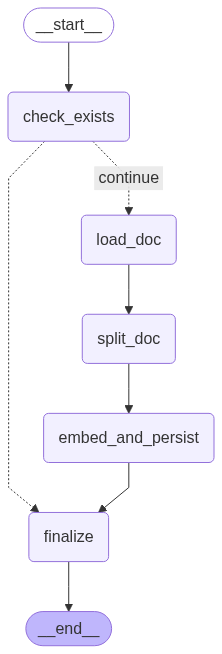

In [14]:
# Create the Graph
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(EmbederState, input_schema=EmbedderInput, output_schema=EmbedderOutput)

workflow.add_node("check_exists", check_file_exists)
workflow.add_node("load_doc", load_documents)
workflow.add_node("split_doc", split_documents)  # new splitting node
workflow.add_node("embed_and_persist", embed_and_persist)
workflow.add_node("finalize", finalize)

workflow.add_edge(START, "check_exists")
workflow.add_conditional_edges(
    "check_exists",
    lambda state: "continue" if state.file_exists else "finalize",
    {
        "continue": "load_doc",
        "finalize": "finalize",
    },
)
workflow.add_edge("load_doc", "split_doc")  # split after loading
workflow.add_edge("split_doc", "embed_and_persist")
workflow.add_edge("embed_and_persist", "finalize")
workflow.add_edge("finalize", END)

graph = workflow.compile()

graph

## Testing the Graph on various file types

In [15]:
# Invoke the graph
embedder_input=EmbedderInput(
    file_path="temp/Coding-Round-Task.pdf",
    vector_db_path="DATA/vector_db"
)

# Create initial state from input
initial_state = EmbederState(**embedder_input)

# Invoke the embedder graph
result_state = graph.invoke(initial_state)

print("Embedder Agent Output:")
result_state

Could get FontBBox from font descriptor because None cannot be parsed as 4 floats (pdffont.py:967)
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats (pdffont.py:967)
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats (pdffont.py:967)
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats (pdffont.py:967)
Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information. (posthog.py:22)
Embedder Agent Output:


{'success': True, 'message': 'VectorDB created successfully'}

In [ ]:
# Invoke the graph
embedder_input=EmbedderInput(
    file_path="temp/presentation-batch-17.pptx",
    vector_db_path="temp/vector_db"
)

# Create initial state from input
#initial_state = EmbederState(**embedder_input)

# Invoke the embedder graph
#result_state = graph.invoke(initial_state)

#print("Embedder Agent Output:")
#result_state

In [ ]:
# Invoke the graph
embedder_input=EmbedderInput(
    file_path="temp/heart-disease.csv",
    vector_db_path="temp/vector_db"
)

# Create initial state from input
#initial_state = EmbederState(**embedder_input)

# Invoke the embedder graph
#result_state = graph.invoke(initial_state)

#print("Embedder Agent Output:")
#result_state

In [ ]:
# Invoke the graph
embedder_input=EmbedderInput(
    file_path="temp/HyperSpectral Imaging Guide.docx",
    vector_db_path="temp/vector_db"
)

# Create initial state from input
#initial_state = EmbederState(**embedder_input)

# Invoke the embedder graph
#result_state = graph.invoke(initial_state)

#print("Embedder Agent Output:")
#result_state

In [ ]:
# Invoke the graph
embedder_input=EmbedderInput(
    file_path="temp/README.md",
    vector_db_path="temp/vector_db"
)

# Create initial state from input
#initial_state = EmbederState(**embedder_input)

# Invoke the embedder graph
#result_state = graph.invoke(initial_state)

#print("Embedder Agent Output:")
#result_state

## Retriever Agent

In [16]:
class RetrieverInput(TypedDict):
    vector_db_path: str
    retriever_path: str
    query: str
    
class RetrieverOutput(TypedDict):
    results: List[Document]

In [17]:
# Check if vector DB exists and is non-empty
def check_vector_db(state: RetrieverState)-> RetrieverState:
    """Check if the vector DB exists and is non-empty."""
    path = state.vector_db_path
    state.vector_db_ready = os.path.exists(path) and bool(os.listdir(path))
    return state

In [18]:
# Load vectorDB and create retriever

# External cache for retriever instances keyed by retriever_path
retriever_cache = {}

def create_retriever(state: RetrieverState)-> RetrieverState:
    if not state.vector_db_ready:
        raise FileNotFoundError(f" VectorDB not found or empty at {state.vector_db_path}")
    
    if state.retriever_path not in retriever_cache:
        embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
        vector_db=Chroma(
            persist_directory=state.vector_db_path, 
            embedding_function=embeddings
        )
        retriever_cache[state.retriever_path] = vector_db.as_retriever()
    
    state.retriever_ready = True
    return state

    

In [19]:
# Perform retrieval based on query
def retrieve(state: RetrieverState)-> RetrieverState:
    if not state.retriever_ready:
        raise RuntimeError("Retriever not ready")
    
    retriever = retriever_cache.get(state.retriever_path)
    if retriever is None:
        raise RuntimeError("Retriever instance missing")
    
    state.results = retriever.get_relevant_documents(state.query)
    return state

In [20]:
# Finalize and return MCP output
def finalize(state: RetrieverState) -> RetrieverOutput:
    return {"results": state.results}

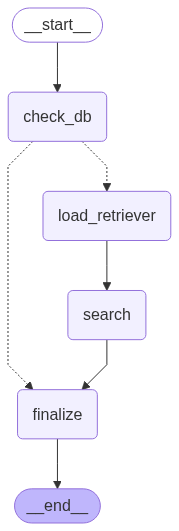

In [21]:
# Build the retriever graph
builder = StateGraph(RetrieverState, input_schema=RetrieverInput, output_schema=RetrieverOutput)

builder.add_node("check_db", check_vector_db)
builder.add_node("load_retriever", create_retriever)
builder.add_node("search", retrieve)
builder.add_node("finalize", finalize)

builder.add_edge(START, "check_db")
builder.add_conditional_edges(
    "check_db",
    lambda state: "load_retriever" if state.vector_db_ready else "finalize",
    {
        "load_retriever": "load_retriever",
        "finalize": "finalize",
    },
)
builder.add_edge("load_retriever", "search")
builder.add_edge("search", "finalize")
builder.add_edge("finalize", END)

retriever_graph = builder.compile()
retriever_graph

## Testing the Retriever Agent

In [22]:
# Prepare input
retriever_input = RetrieverInput(
    vector_db_path="DATA/vector_db",
    retriever_path="DATA/retriever",
    query="What is the problem statement?"
)

# Create initial state from input
initial_state = RetrieverState(
    vector_db_path=retriever_input["vector_db_path"],
    retriever_path=retriever_input["retriever_path"],
    query=retriever_input["query"],
    retriever_ready=False,
    results=[]
)

# Invoke the retriever graph
result_state = retriever_graph.invoke(initial_state)

# Print final output (RetrieverOutput)
print("Retriever Agent Output:")
print(result_state)  # This will be RetrieverOutput TypedDict if finalize node returns it

# To print retrieved documents content:
for doc in result_state.get("results", []):
    print(doc.page_content)

/var/folders/vm/62zyvxyx70qb5rrghd3vfnx80000gn/T/ipykernel_87055/642640264.py:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_db=Chroma(
/var/folders/vm/62zyvxyx70qb5rrghd3vfnx80000gn/T/ipykernel_87055/1255622377.py:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  state.results = retriever.get_relevant_documents(state.query)


Retriever Agent Output:
{'results': [Document(metadata={'page': 1, 'source': 'temp/Coding-Round-Task.pdf', 'total_pages': 3, 'Producer': 'Skia/PDF m139 Google Docs Renderer', 'Title': 'Coding Round Task', 'file_path': 'temp/Coding-Round-Task.pdf'}, page_content='○ You can implement MCP using in-memory messaging, REST, or pub/sub.\n4. Vector Store + Embeddings\n○ Use any embeddings (OpenAI, HuggingFace, etc.)\n○ Use a vector DB (FAISS, Chroma, etc.)\n5. Chatbot Interface (UI)\n○ Allow users to:\n■ Upload documents\n■ Ask multi-turn questions\n■ View responses with source context\n○ Use any UI framework: Streamlit, React, Angular, Flask, etc.\n📸 Deliverables\n1. 📁 GitHub Repository\n○ Include:\n■ Well-organized code\n■ Clear README.md with setup instructions\n2. 📊 PPT Presentation\n○ Slide deck (3–6 slides) must include:\n■ Agent-based architecture with MCP integration\n■ System flow diagram (with message passing)\n■ Tech stack used\n■ 📸 UI screenshots of working app\n■ Challenges Faced 

In [ ]:
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient

async def main():
    # Initialize MCP client with embedder and retriever agent endpoints
    client = MultiServerMCPClient({
        "embedder": {
            "url": "https://your-embedder-agent/mcp",
            "transport": "streamable_http",
        },
        "retriever": {
            "url": "https://your-retriever-agent/mcp",
            "transport": "streamable_http",
        }
    })

    try:
        # Fetch available tools from MCP servers
        tools = await client.get_tools()

        # Invoke embedder agent tool with file and vector DB path
        embedder_tool = tools.get("embedder")
        if embedder_tool is None:
            raise RuntimeError("Embedder tool not found in MCP client")

        embed_response = await embedder_tool.invoke({
            "file_path": "temp/Coding-Round-Task.pdf",
            "vector_db_path": "temp/vector_db"
        })
        print("Embedder response:", embed_response)

        # Check embedder success before proceeding
        if not embed_response.get("success", False):
            print("Embedding failed, aborting retrieval")
            return

        # Invoke retriever agent tool with vector DB path and query
        retriever_tool = tools.get("retriever")
        if retriever_tool is None:
            raise RuntimeError("Retriever tool not found in MCP client")

        retriever_response = await retriever_tool.invoke({
            "vector_db_path": "temp/vector_db",
            "query": "What is LangChain?"
        })
        print("Retriever results:", retriever_response)

    except Exception as e:
        print(f"Error during MCP client operations: {e}")

if __name__ == "__main__":
    asyncio.run(main())
